In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [9]:
def calculate_target(row):
    global fee, delta, stop_loss, treshold
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + treshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, treshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(calculate_target, axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
treshold = 300
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, treshold)
gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0      -1
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0      -1
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.5,57000.0,57550.0,56540.0,56650.0,-1.0
2006-06-14,-304.0,57350.0,57950.0,56950.0,57030.0,-1.0
2006-06-15,47.5,58120.0,58250.0,57050.0,58170.0,0.0
2006-06-16,-38.0,57280.0,57840.0,57100.0,57240.0,0.0
2006-06-19,807.5,57200.0,58100.0,56780.0,58050.0,1.0
2006-06-20,1330.0,57700.0,59150.0,57350.0,59100.0,1.0
2006-06-21,-247.0,58800.0,59350.0,58450.0,58540.0,0.0
2006-06-22,1282.5,57450.0,58900.0,57450.0,58800.0,1.0
2006-06-23,142.5,58620.0,58950.0,58000.0,58770.0,0.0


In [11]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,95.593220,-1.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,96.283784,-1.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,83.445946,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,44.932432,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,76.351351,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,48.986486,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,13.513514,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,32.432432,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,23.648649,0.0


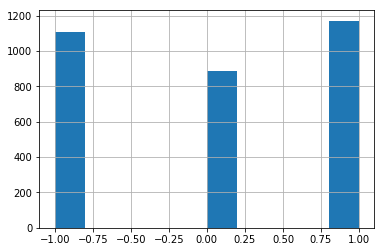

In [12]:
gold['target'].hist()

In [13]:
gold_gains.gains.describe()

count     3167.000000
mean        -8.564099
std       1195.752197
min     -11390.500000
25%       -551.000000
50%         19.000000
75%        598.500000
max       6555.000000
Name: gains, dtype: float64

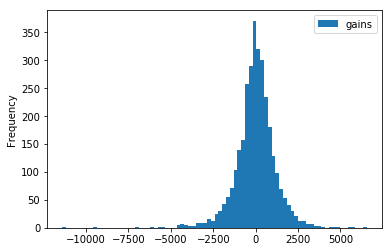

In [14]:
gold_gains[['gains']].plot.hist(bins=80)

In [15]:
gold_gains.head(5)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.5,57000.0,57550.0,56540.0,56650.0,-1.0
2006-06-14,-304.0,57350.0,57950.0,56950.0,57030.0,-1.0
2006-06-15,47.5,58120.0,58250.0,57050.0,58170.0,0.0
2006-06-16,-38.0,57280.0,57840.0,57100.0,57240.0,0.0
2006-06-19,807.5,57200.0,58100.0,56780.0,58050.0,1.0


In [16]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [17]:
gold_gains = stop_loss_gen(gold_gains)

In [61]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')

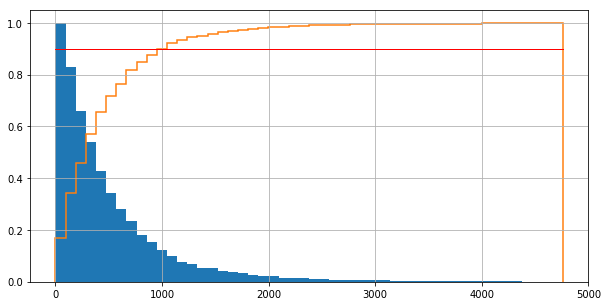

In [62]:
plot_histogram_cumsum(gold_gains[gold_gains.target == 1], 'Open_Low')

In [20]:
gold_gains[gold_gains.target == 1].Open_Low.describe()

count    1172.000000
mean      468.242321
std       512.238752
min         0.000000
25%       140.000000
50%       320.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [21]:
gold_gains[gold_gains.target == -1].Open_High.describe()

count    1108.000000
mean      443.655235
std       468.596374
min         0.000000
25%       150.000000
50%       330.000000
75%       582.500000
max      6150.000000
Name: Open_High, dtype: float64

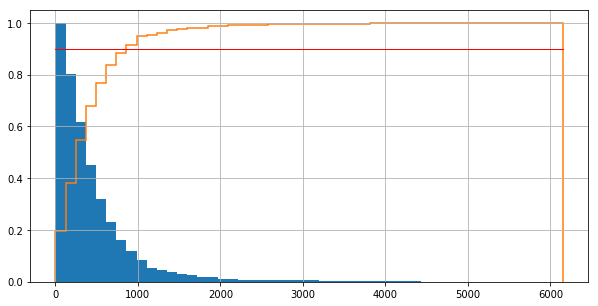

In [63]:
plot_histogram_cumsum(gold_gains[gold_gains.target == -1], 'Open_High')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


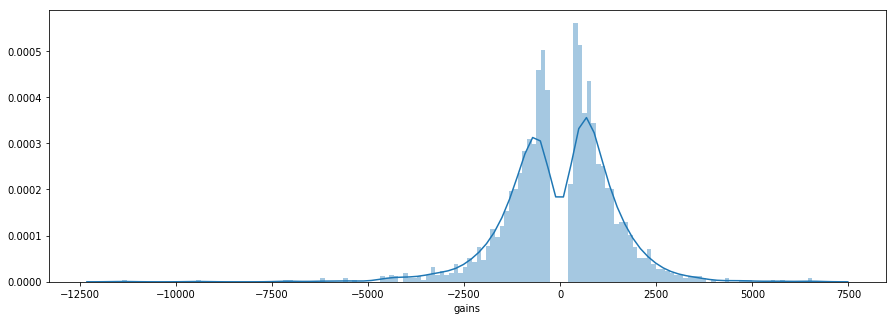

In [44]:
sr = gold_gains.loc[gold_gains.index < '2018-01-01'][gold_gains.gains.abs() > 300].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=150, ax=ax)

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
treshold = 150
corn_gains = create_trade_outcomes(corn, contracts, treshold)
corn_gains.head(5)

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0


In [24]:
corn_gains.gains.describe()

count    3158.000000
mean        5.730684
std       398.409134
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       201.875000
max      1888.125000
Name: gains, dtype: float64

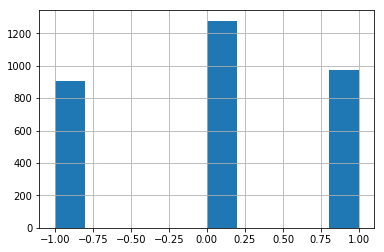

In [25]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.target.hist()

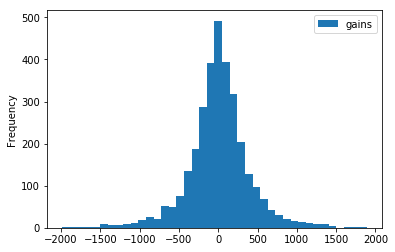

In [26]:
corn_gains[['gains']].plot.hist(bins=40)

In [27]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)

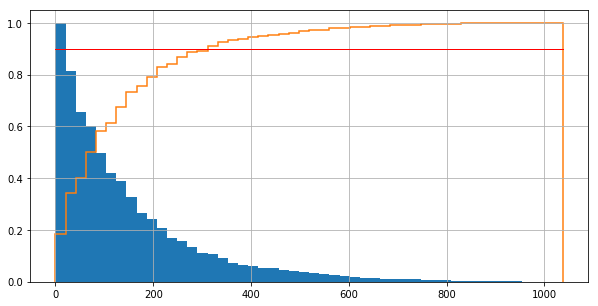

In [64]:
plot_histogram_cumsum(corn_gains[corn_gains.target == 1], 'Open_Low')

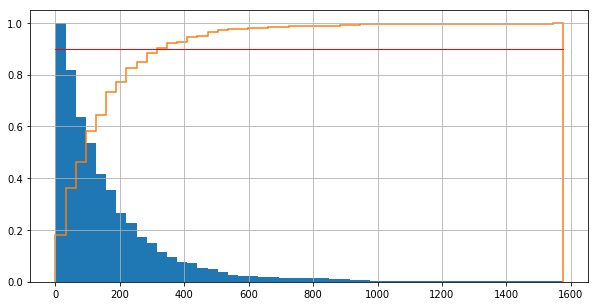

In [65]:
plot_histogram_cumsum(corn_gains[corn_gains.target == -1], 'Open_High')

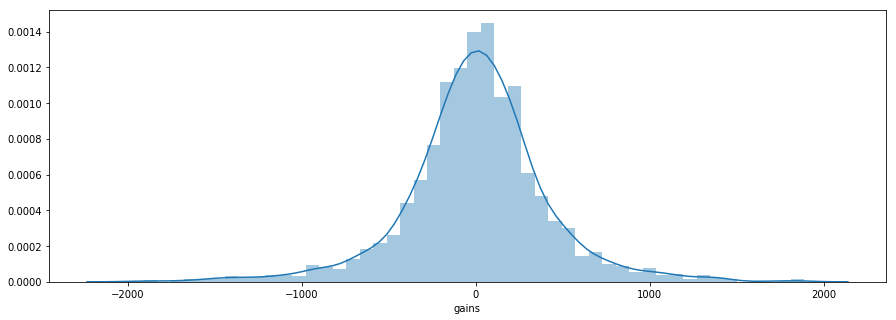

In [32]:
sr = corn_gains.loc[corn_gains.index < '2018-01-01'].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, ax=ax)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


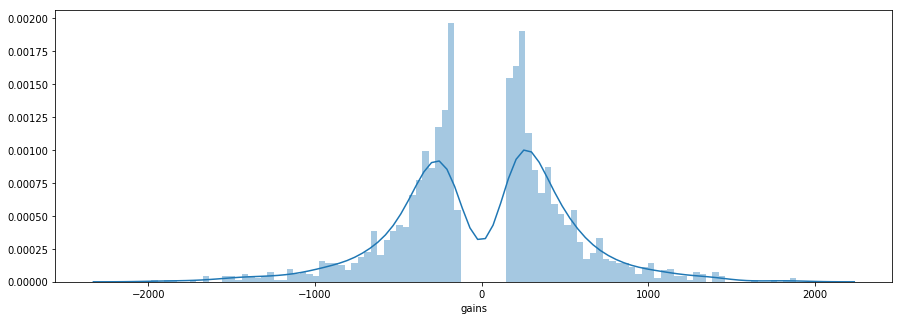

In [41]:
sr = corn_gains.loc[corn_gains.index < '2018-01-01'][corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [69]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
treshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, treshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains.head(5)

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


,gains,Open,High,Low,Settle,target,Open_High,Open_Low
Date,,,,,,,,
2006-06-13,0.0,36918.75,37275.0,36600.0,36918.75,0.0,356.25,318.75
2006-06-14,0.0,37106.25,37425.0,36937.5,37106.25,0.0,318.75,168.75
2006-06-15,0.0,36637.50,37350.0,36337.5,36637.50,0.0,712.50,300.00
2006-06-16,0.0,36468.75,36712.5,36375.0,36468.75,0.0,243.75,93.75
2006-06-19,0.0,36543.75,37162.5,36487.5,36543.75,0.0,618.75,56.25


In [70]:
coffee_gains.gains.describe()

count    3148.000000
mean      -15.860368
std      1042.083421
min     -5236.875000
25%      -498.750000
50%         0.000000
75%       480.937500
max      6341.250000
Name: gains, dtype: float64

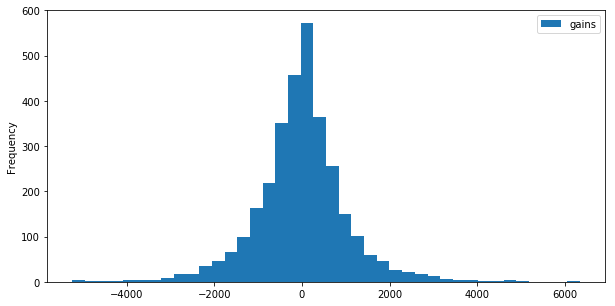

In [71]:
coffee_gains[['gains']].plot.hist(bins=40, figsize=(10, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb56bb6deb8>,
      dtype=object)

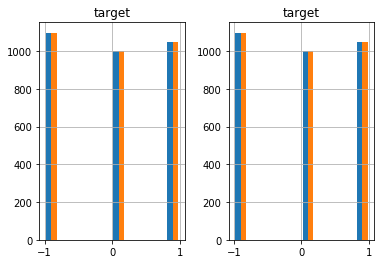

In [72]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.target.hist()

In [50]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
2006-11-13,115.15,116.70,114.50,115.15,18584.0,36595.0,32.442748,1.0
2006-11-14,119.25,121.30,119.25,120.15,14200.0,69469.0,7.666667,1.0
2006-11-15,120.25,122.70,120.15,122.45,19154.0,72935.0,1.524390,-1.0
2006-11-16,124.20,124.75,120.75,120.95,15359.0,75743.0,21.052632,-1.0
2006-11-17,119.25,119.90,116.00,117.95,24817.0,80514.0,38.095238,1.0
2006-11-22,119.75,120.40,119.40,120.15,4626.0,83919.0,34.074074,1.0
2006-11-27,121.00,122.85,120.20,122.65,8685.0,84499.0,16.216216,1.0
2006-11-29,124.00,126.80,123.00,123.30,14743.0,86373.0,23.489933,1.0
2006-11-30,123.30,125.40,123.30,124.30,10281.0,87848.0,20.325203,1.0


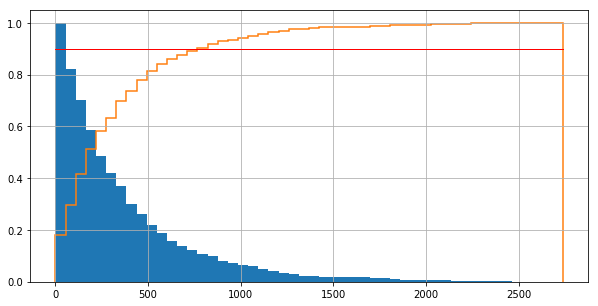

In [73]:
plot_histogram_cumsum(coffee_gains[coffee_gains.target == 1], 'Open_Low')

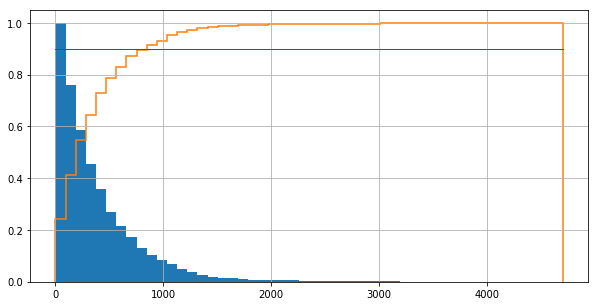

In [74]:
plot_histogram_cumsum(coffee_gains[coffee_gains.target == -1], 'Open_High')

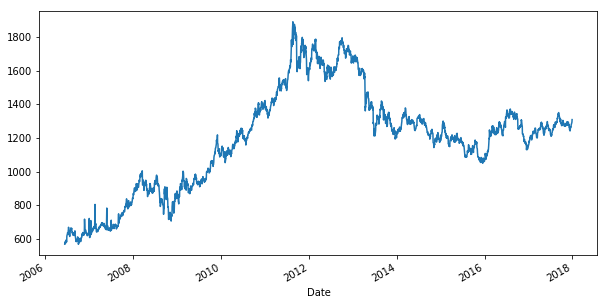

In [54]:
gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(10, 5))

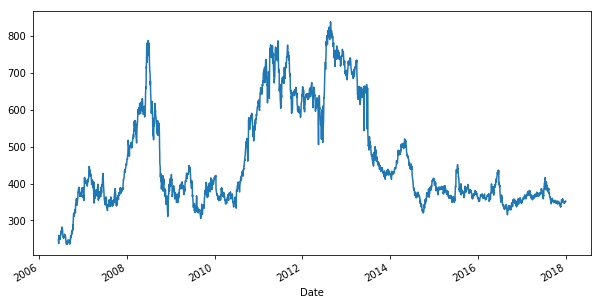

In [55]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

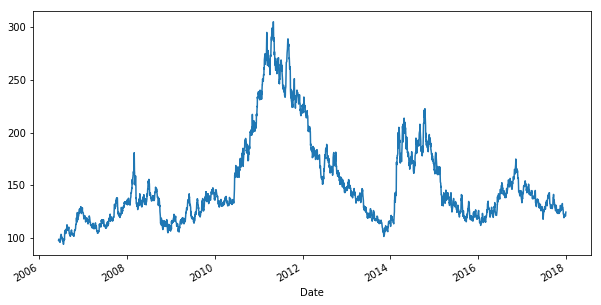

In [57]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

In [62]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

ModuleNotFoundError: No module named 'holidays'

In [28]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [29]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,1.0


In [30]:
gold_data.shape

(5276, 3046)

In [31]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [32]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [33]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3045
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    # df_train = pd.DataFrame(df_train)
    # df_test = pd.DataFrame(df_test)

    # pca_lst = []
    # pca = PCA(n_components=50, random_state=2234)
    pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(3040))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)
    # return df_train[list(range(label_index))], df_train[label_index], df_validate[list(range(label_index))], df_validate[label_index], pca    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3040))])
    # df_pca = pd.DataFrame(df_pca, index=df.index)
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    # df_pca = pd.concat([df_pca, df[list(range(3040, label_index))]], axis=1)
    return df_pca

In [34]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
# gold_train, gold_label_train, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [23]:
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_),
         np.cumsum(corn_pca.explained_variance_ratio_),
         np.cumsum(coffee_pca.explained_variance_ratio_)
        )
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

NameError: name 'np' is not defined

In [36]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [37]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2007-01-02,443.3,444.0,434.4,437.0,67906.0,226150.0,436.0,439.8,434.7,438.4,...,0.531691,0.369919,0.484046,0.336928,1,2,1,0,0.000000,-1.0
2007-01-03,436.0,439.8,434.7,438.4,32949.0,217477.0,435.8,436.3,427.8,429.7,...,0.531691,0.369919,0.484046,0.336928,2,3,1,0,85.984848,0.0
2007-01-04,435.8,436.3,427.8,429.7,82846.0,208448.0,427.4,429.7,424.8,429.2,...,0.484046,0.336928,0.345193,0.474129,3,4,1,0,89.393939,-1.0
2007-01-05,427.4,429.7,424.8,429.2,54829.0,202128.0,426.3,429.3,426.1,427.3,...,0.484046,0.336928,0.345193,0.474129,4,5,1,0,96.683673,0.0
2007-01-08,426.3,429.3,426.1,427.3,43721.0,196268.0,425.7,427.0,421.1,421.6,...,0.484046,0.336928,0.345193,0.474129,0,6,1,0,94.557823,1.0
2007-01-09,425.7,427.0,421.1,421.6,65179.0,188605.0,421.2,425.8,417.1,419.5,...,0.484046,0.336928,0.345193,0.474129,1,7,1,0,89.795918,0.0
2007-01-10,421.2,425.8,417.1,419.5,97972.0,176117.0,419.7,421.3,419.5,419.7,...,0.345193,0.474129,0.801490,0.141280,2,8,1,0,91.156463,0.0
2007-01-11,419.7,421.3,419.5,419.7,34177.0,172080.0,421.3,423.3,421.1,422.4,...,0.345193,0.474129,0.801490,0.141280,3,9,1,0,90.731293,1.0
2007-01-12,421.3,423.3,421.1,422.4,46900.0,164267.0,421.7,428.3,421.1,426.6,...,0.345193,0.474129,0.801490,0.141280,4,10,1,0,79.676871,0.0
2007-01-15,421.7,428.3,421.1,426.6,64043.0,164973.0,424.1,425.5,423.6,425.1,...,0.345193,0.474129,0.801490,0.141280,0,1,1,0,10.629252,0.0


In [38]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

categoricals = [5, 6, 7, 8]
# categoricals = 'auto'
# categoricals = [3040,3041,3042,3043]
X = pca_transform(gold_train, gold_pca)
y = list(map(lambda x: 1 if x < 0 else 0, gold_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, gold_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)

gold_short = True

param = {'num_leaves':31, 'objective':'binary'}
param['objective'] = 'binary'
param['boosting'] = 'dart'
param['metric'] = 'binary_error'
param['learning_rate'] = 0.05
param['num_class'] = 1
param['max_bin'] = 50
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 3000

gold_xgb_use = False
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_error: 0.362657
[2]	valid_0's binary_error: 0.362657
[3]	valid_0's binary_error: 0.362657
[4]	valid_0's binary_error: 0.362657
[5]	valid_0's binary_error: 0.362657
[6]	valid_0's binary_error: 0.362657
[7]	valid_0's binary_error: 0.362657
[8]	valid_0's binary_error: 0.362657
[9]	valid_0's binary_error: 0.362657
[10]	valid_0's binary_error: 0.362657
[11]	valid_0's binary_error: 0.362657
[12]	valid_0's binary_error: 0.362657
[13]	valid_0's binary_error: 0.362657
[14]	valid_0's binary_error: 0.362657
[15]	valid_0's binary_error: 0.362657
[16]	valid_0's binary_error: 0.362657
[17]	valid_0's binary_error: 0.362657
[18]	valid_0's binary_error: 0.362657
[19]	valid_0's binary_error: 0.362657
[20]	valid_0's binary_error: 0.362657
[21]	valid_0's binary_error: 0.362657
[22]	valid_0's binary_error: 0.362657
[23]	valid_0's binary_error: 0.362657
[24]	valid_0's binary_error: 0.362657
[25]	valid_0's binary_error: 0.362657
[26]	valid_0's binary_error: 0.362657
[27]	valid_0's binary

[256]	valid_0's binary_error: 0.384201
[257]	valid_0's binary_error: 0.384201
[258]	valid_0's binary_error: 0.384201
[259]	valid_0's binary_error: 0.384201
[260]	valid_0's binary_error: 0.384201
[261]	valid_0's binary_error: 0.384201
[262]	valid_0's binary_error: 0.384201
[263]	valid_0's binary_error: 0.384201
[264]	valid_0's binary_error: 0.384201
[265]	valid_0's binary_error: 0.384201
[266]	valid_0's binary_error: 0.382406
[267]	valid_0's binary_error: 0.382406
[268]	valid_0's binary_error: 0.384201
[269]	valid_0's binary_error: 0.385996
[270]	valid_0's binary_error: 0.38061
[271]	valid_0's binary_error: 0.38061
[272]	valid_0's binary_error: 0.38061
[273]	valid_0's binary_error: 0.38061
[274]	valid_0's binary_error: 0.38061
[275]	valid_0's binary_error: 0.385996
[276]	valid_0's binary_error: 0.385996
[277]	valid_0's binary_error: 0.385996
[278]	valid_0's binary_error: 0.385996
[279]	valid_0's binary_error: 0.384201
[280]	valid_0's binary_error: 0.384201
[281]	valid_0's binary_error: 

[473]	valid_0's binary_error: 0.384201
[474]	valid_0's binary_error: 0.385996
[475]	valid_0's binary_error: 0.385996
[476]	valid_0's binary_error: 0.385996
[477]	valid_0's binary_error: 0.384201
[478]	valid_0's binary_error: 0.384201
[479]	valid_0's binary_error: 0.384201
[480]	valid_0's binary_error: 0.384201
[481]	valid_0's binary_error: 0.384201
[482]	valid_0's binary_error: 0.384201
[483]	valid_0's binary_error: 0.385996
[484]	valid_0's binary_error: 0.385996
[485]	valid_0's binary_error: 0.385996
[486]	valid_0's binary_error: 0.385996
[487]	valid_0's binary_error: 0.385996
[488]	valid_0's binary_error: 0.387792
[489]	valid_0's binary_error: 0.389587
[490]	valid_0's binary_error: 0.387792
[491]	valid_0's binary_error: 0.387792
[492]	valid_0's binary_error: 0.387792
[493]	valid_0's binary_error: 0.387792
[494]	valid_0's binary_error: 0.387792
[495]	valid_0's binary_error: 0.391382
[496]	valid_0's binary_error: 0.391382
[497]	valid_0's binary_error: 0.391382
[498]	valid_0's binary_er

[689]	valid_0's binary_error: 0.391382
[690]	valid_0's binary_error: 0.389587
[691]	valid_0's binary_error: 0.389587
[692]	valid_0's binary_error: 0.389587
[693]	valid_0's binary_error: 0.385996
[694]	valid_0's binary_error: 0.387792
[695]	valid_0's binary_error: 0.387792
[696]	valid_0's binary_error: 0.387792
[697]	valid_0's binary_error: 0.389587
[698]	valid_0's binary_error: 0.387792
[699]	valid_0's binary_error: 0.389587
[700]	valid_0's binary_error: 0.389587
[701]	valid_0's binary_error: 0.387792
[702]	valid_0's binary_error: 0.387792
[703]	valid_0's binary_error: 0.389587
[704]	valid_0's binary_error: 0.389587
[705]	valid_0's binary_error: 0.389587
[706]	valid_0's binary_error: 0.389587
[707]	valid_0's binary_error: 0.389587
[708]	valid_0's binary_error: 0.389587
[709]	valid_0's binary_error: 0.389587
[710]	valid_0's binary_error: 0.387792
[711]	valid_0's binary_error: 0.387792
[712]	valid_0's binary_error: 0.387792
[713]	valid_0's binary_error: 0.387792
[714]	valid_0's binary_er

[917]	valid_0's binary_error: 0.394973
[918]	valid_0's binary_error: 0.394973
[919]	valid_0's binary_error: 0.394973
[920]	valid_0's binary_error: 0.394973
[921]	valid_0's binary_error: 0.394973
[922]	valid_0's binary_error: 0.394973
[923]	valid_0's binary_error: 0.393178
[924]	valid_0's binary_error: 0.394973
[925]	valid_0's binary_error: 0.393178
[926]	valid_0's binary_error: 0.394973
[927]	valid_0's binary_error: 0.394973
[928]	valid_0's binary_error: 0.394973
[929]	valid_0's binary_error: 0.391382
[930]	valid_0's binary_error: 0.394973
[931]	valid_0's binary_error: 0.393178
[932]	valid_0's binary_error: 0.393178
[933]	valid_0's binary_error: 0.393178
[934]	valid_0's binary_error: 0.389587
[935]	valid_0's binary_error: 0.393178
[936]	valid_0's binary_error: 0.393178
[937]	valid_0's binary_error: 0.391382
[938]	valid_0's binary_error: 0.394973
[939]	valid_0's binary_error: 0.394973
[940]	valid_0's binary_error: 0.394973
[941]	valid_0's binary_error: 0.394973
[942]	valid_0's binary_er

[1138]	valid_0's binary_error: 0.394973
[1139]	valid_0's binary_error: 0.394973
[1140]	valid_0's binary_error: 0.394973
[1141]	valid_0's binary_error: 0.394973
[1142]	valid_0's binary_error: 0.394973
[1143]	valid_0's binary_error: 0.393178
[1144]	valid_0's binary_error: 0.391382
[1145]	valid_0's binary_error: 0.391382
[1146]	valid_0's binary_error: 0.391382
[1147]	valid_0's binary_error: 0.393178
[1148]	valid_0's binary_error: 0.393178
[1149]	valid_0's binary_error: 0.393178
[1150]	valid_0's binary_error: 0.393178
[1151]	valid_0's binary_error: 0.393178
[1152]	valid_0's binary_error: 0.393178
[1153]	valid_0's binary_error: 0.393178
[1154]	valid_0's binary_error: 0.393178
[1155]	valid_0's binary_error: 0.393178
[1156]	valid_0's binary_error: 0.393178
[1157]	valid_0's binary_error: 0.393178
[1158]	valid_0's binary_error: 0.393178
[1159]	valid_0's binary_error: 0.393178
[1160]	valid_0's binary_error: 0.391382
[1161]	valid_0's binary_error: 0.391382
[1162]	valid_0's binary_error: 0.391382


[1375]	valid_0's binary_error: 0.409336
[1376]	valid_0's binary_error: 0.409336
[1377]	valid_0's binary_error: 0.409336
[1378]	valid_0's binary_error: 0.409336
[1379]	valid_0's binary_error: 0.409336
[1380]	valid_0's binary_error: 0.409336
[1381]	valid_0's binary_error: 0.409336
[1382]	valid_0's binary_error: 0.409336
[1383]	valid_0's binary_error: 0.409336
[1384]	valid_0's binary_error: 0.409336
[1385]	valid_0's binary_error: 0.409336
[1386]	valid_0's binary_error: 0.409336
[1387]	valid_0's binary_error: 0.409336
[1388]	valid_0's binary_error: 0.409336
[1389]	valid_0's binary_error: 0.409336
[1390]	valid_0's binary_error: 0.405745
[1391]	valid_0's binary_error: 0.405745
[1392]	valid_0's binary_error: 0.40754
[1393]	valid_0's binary_error: 0.40754
[1394]	valid_0's binary_error: 0.40754
[1395]	valid_0's binary_error: 0.40754
[1396]	valid_0's binary_error: 0.40754
[1397]	valid_0's binary_error: 0.40754
[1398]	valid_0's binary_error: 0.40754
[1399]	valid_0's binary_error: 0.40754
[1400]	v

[1605]	valid_0's binary_error: 0.425494
[1606]	valid_0's binary_error: 0.427289
[1607]	valid_0's binary_error: 0.427289
[1608]	valid_0's binary_error: 0.427289
[1609]	valid_0's binary_error: 0.425494
[1610]	valid_0's binary_error: 0.423698
[1611]	valid_0's binary_error: 0.423698
[1612]	valid_0's binary_error: 0.423698
[1613]	valid_0's binary_error: 0.423698
[1614]	valid_0's binary_error: 0.423698
[1615]	valid_0's binary_error: 0.423698
[1616]	valid_0's binary_error: 0.423698
[1617]	valid_0's binary_error: 0.423698
[1618]	valid_0's binary_error: 0.423698
[1619]	valid_0's binary_error: 0.423698
[1620]	valid_0's binary_error: 0.425494
[1621]	valid_0's binary_error: 0.429084
[1622]	valid_0's binary_error: 0.427289
[1623]	valid_0's binary_error: 0.427289
[1624]	valid_0's binary_error: 0.429084
[1625]	valid_0's binary_error: 0.425494
[1626]	valid_0's binary_error: 0.423698
[1627]	valid_0's binary_error: 0.423698
[1628]	valid_0's binary_error: 0.423698
[1629]	valid_0's binary_error: 0.425494


[1815]	valid_0's binary_error: 0.418312
[1816]	valid_0's binary_error: 0.418312
[1817]	valid_0's binary_error: 0.418312
[1818]	valid_0's binary_error: 0.418312
[1819]	valid_0's binary_error: 0.418312
[1820]	valid_0's binary_error: 0.420108
[1821]	valid_0's binary_error: 0.420108
[1822]	valid_0's binary_error: 0.420108
[1823]	valid_0's binary_error: 0.418312
[1824]	valid_0's binary_error: 0.418312
[1825]	valid_0's binary_error: 0.418312
[1826]	valid_0's binary_error: 0.420108
[1827]	valid_0's binary_error: 0.420108
[1828]	valid_0's binary_error: 0.421903
[1829]	valid_0's binary_error: 0.421903
[1830]	valid_0's binary_error: 0.421903
[1831]	valid_0's binary_error: 0.421903
[1832]	valid_0's binary_error: 0.420108
[1833]	valid_0's binary_error: 0.420108
[1834]	valid_0's binary_error: 0.416517
[1835]	valid_0's binary_error: 0.416517
[1836]	valid_0's binary_error: 0.416517
[1837]	valid_0's binary_error: 0.416517
[1838]	valid_0's binary_error: 0.416517
[1839]	valid_0's binary_error: 0.418312


[2032]	valid_0's binary_error: 0.418312
[2033]	valid_0's binary_error: 0.418312
[2034]	valid_0's binary_error: 0.418312
[2035]	valid_0's binary_error: 0.414722
[2036]	valid_0's binary_error: 0.416517
[2037]	valid_0's binary_error: 0.416517
[2038]	valid_0's binary_error: 0.416517
[2039]	valid_0's binary_error: 0.416517
[2040]	valid_0's binary_error: 0.418312
[2041]	valid_0's binary_error: 0.418312
[2042]	valid_0's binary_error: 0.421903
[2043]	valid_0's binary_error: 0.421903
[2044]	valid_0's binary_error: 0.421903
[2045]	valid_0's binary_error: 0.421903
[2046]	valid_0's binary_error: 0.421903
[2047]	valid_0's binary_error: 0.421903
[2048]	valid_0's binary_error: 0.421903
[2049]	valid_0's binary_error: 0.421903
[2050]	valid_0's binary_error: 0.421903
[2051]	valid_0's binary_error: 0.420108
[2052]	valid_0's binary_error: 0.418312
[2053]	valid_0's binary_error: 0.418312
[2054]	valid_0's binary_error: 0.414722
[2055]	valid_0's binary_error: 0.414722
[2056]	valid_0's binary_error: 0.414722


[2268]	valid_0's binary_error: 0.43088
[2269]	valid_0's binary_error: 0.43088
[2270]	valid_0's binary_error: 0.43088
[2271]	valid_0's binary_error: 0.43088
[2272]	valid_0's binary_error: 0.43088
[2273]	valid_0's binary_error: 0.43088
[2274]	valid_0's binary_error: 0.43088
[2275]	valid_0's binary_error: 0.43088
[2276]	valid_0's binary_error: 0.43088
[2277]	valid_0's binary_error: 0.432675
[2278]	valid_0's binary_error: 0.432675
[2279]	valid_0's binary_error: 0.432675
[2280]	valid_0's binary_error: 0.432675
[2281]	valid_0's binary_error: 0.432675
[2282]	valid_0's binary_error: 0.432675
[2283]	valid_0's binary_error: 0.432675
[2284]	valid_0's binary_error: 0.429084
[2285]	valid_0's binary_error: 0.429084
[2286]	valid_0's binary_error: 0.429084
[2287]	valid_0's binary_error: 0.429084
[2288]	valid_0's binary_error: 0.429084
[2289]	valid_0's binary_error: 0.429084
[2290]	valid_0's binary_error: 0.429084
[2291]	valid_0's binary_error: 0.429084
[2292]	valid_0's binary_error: 0.429084
[2293]	va

[2481]	valid_0's binary_error: 0.43088
[2482]	valid_0's binary_error: 0.43088
[2483]	valid_0's binary_error: 0.43088
[2484]	valid_0's binary_error: 0.429084
[2485]	valid_0's binary_error: 0.429084
[2486]	valid_0's binary_error: 0.429084
[2487]	valid_0's binary_error: 0.429084
[2488]	valid_0's binary_error: 0.429084
[2489]	valid_0's binary_error: 0.429084
[2490]	valid_0's binary_error: 0.429084
[2491]	valid_0's binary_error: 0.429084
[2492]	valid_0's binary_error: 0.429084
[2493]	valid_0's binary_error: 0.429084
[2494]	valid_0's binary_error: 0.429084
[2495]	valid_0's binary_error: 0.429084
[2496]	valid_0's binary_error: 0.429084
[2497]	valid_0's binary_error: 0.429084
[2498]	valid_0's binary_error: 0.429084
[2499]	valid_0's binary_error: 0.429084
[2500]	valid_0's binary_error: 0.429084
[2501]	valid_0's binary_error: 0.429084
[2502]	valid_0's binary_error: 0.429084
[2503]	valid_0's binary_error: 0.429084
[2504]	valid_0's binary_error: 0.429084
[2505]	valid_0's binary_error: 0.429084
[25

[2688]	valid_0's binary_error: 0.423698
[2689]	valid_0's binary_error: 0.423698
[2690]	valid_0's binary_error: 0.425494
[2691]	valid_0's binary_error: 0.423698
[2692]	valid_0's binary_error: 0.423698
[2693]	valid_0's binary_error: 0.421903
[2694]	valid_0's binary_error: 0.421903
[2695]	valid_0's binary_error: 0.423698
[2696]	valid_0's binary_error: 0.420108
[2697]	valid_0's binary_error: 0.420108
[2698]	valid_0's binary_error: 0.420108
[2699]	valid_0's binary_error: 0.420108
[2700]	valid_0's binary_error: 0.420108
[2701]	valid_0's binary_error: 0.420108
[2702]	valid_0's binary_error: 0.420108
[2703]	valid_0's binary_error: 0.420108
[2704]	valid_0's binary_error: 0.420108
[2705]	valid_0's binary_error: 0.420108
[2706]	valid_0's binary_error: 0.420108
[2707]	valid_0's binary_error: 0.420108
[2708]	valid_0's binary_error: 0.420108
[2709]	valid_0's binary_error: 0.420108
[2710]	valid_0's binary_error: 0.420108
[2711]	valid_0's binary_error: 0.420108
[2712]	valid_0's binary_error: 0.420108


[2918]	valid_0's binary_error: 0.43088
[2919]	valid_0's binary_error: 0.432675
[2920]	valid_0's binary_error: 0.43088
[2921]	valid_0's binary_error: 0.43088
[2922]	valid_0's binary_error: 0.43088
[2923]	valid_0's binary_error: 0.43088
[2924]	valid_0's binary_error: 0.43088
[2925]	valid_0's binary_error: 0.43088
[2926]	valid_0's binary_error: 0.43088
[2927]	valid_0's binary_error: 0.43088
[2928]	valid_0's binary_error: 0.43088
[2929]	valid_0's binary_error: 0.43088
[2930]	valid_0's binary_error: 0.43088
[2931]	valid_0's binary_error: 0.429084
[2932]	valid_0's binary_error: 0.429084
[2933]	valid_0's binary_error: 0.429084
[2934]	valid_0's binary_error: 0.429084
[2935]	valid_0's binary_error: 0.429084
[2936]	valid_0's binary_error: 0.429084
[2937]	valid_0's binary_error: 0.429084
[2938]	valid_0's binary_error: 0.43088
[2939]	valid_0's binary_error: 0.43088
[2940]	valid_0's binary_error: 0.43088
[2941]	valid_0's binary_error: 0.43088
[2942]	valid_0's binary_error: 0.43088
[2943]	valid_0's 

In [39]:
%%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: 1 if x < 0 else 0, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
corn_short = True
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [40]:
%%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_train)), categorical_feature='auto')
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_test)), categorical_feature='auto')
coffee_short = True
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [145]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, short=False, multi_class=False, stop_loss=500, vector=False):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if short:
        target = -1
    else:
        target = 1
    preds = model.predict(df)
    # print(np.unique(preds))
    if vector:
        preds = [p[0] for p in preds]
        # ps = []
        # for p, r in preds:
        #     if p > 0.5 and p > r:
        #         ps.append(p)
        # preds = ps
    predictions = []
    if not multi_class:
        mx = 0
        for p in preds:
            if p > mx:
                print(mx)
                mx = p
            if p > 0.5:
                predictions.append(target)
            else:
                predictions.append(0)
    else:
        mx = 0
        for t, n in preds:
            # if t > mx:
            #     print(mx)
            #     mx = t
            if t > 0.5:
                print(t, n)
                predictions.append(target)
            else:
                predictions.append(0)
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1:
            # print("Short ", p, l)
            short = 1
            if (v[2] - v[1]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1:
            long = 1
            if (v[1] - v[3]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(p)
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

[0.02039971 0.03946943 0.04822599 0.05576774 0.0631357  0.06443152
 0.06765647 0.07079277 0.07834219 0.08058463 0.08233168 0.08326721
 0.08741733 0.08842746 0.09500619 0.0952076  0.09849404 0.09930166
 0.09977002 0.10361422 0.10521647 0.10606144 0.10672495 0.11156076
 0.11246822 0.11348435 0.11588238 0.11643182 0.11714448 0.11779925
 0.12004193 0.12121152 0.12581993 0.12631828 0.12695803 0.13475492
 0.13606299 0.14049859 0.1406802  0.1422434  0.14535728 0.14658103
 0.14707534 0.14761879 0.15414619 0.15467129 0.15656475 0.15763573
 0.15933444 0.16099355 0.16205453 0.16291536 0.16324244 0.16590065
 0.1673813  0.16849276 0.17031614 0.17045166 0.1712446  0.17137113
 0.17228326 0.17526538 0.17639022 0.18810785 0.1925783  0.19653775
 0.19676748 0.19815235 0.19819053 0.19819878 0.19955414 0.19971203
 0.20255237 0.20480559 0.20856314 0.2086693  0.20951687 0.21476498
 0.21529306 0.21638528 0.21834044 0.21883464 0.22059406 0.22312204
 0.22375284 0.22436374 0.22491787 0.2285282  0.2289103  0.2296

(0, 18000)

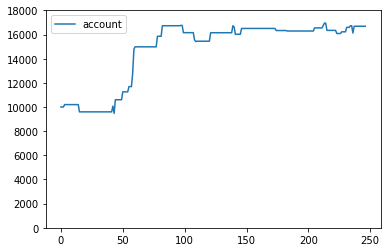

In [42]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=gold_short, stop_loss=600)
ax1 = gold_account[['account']].plot()
ax1.set_ylim(0,18000)

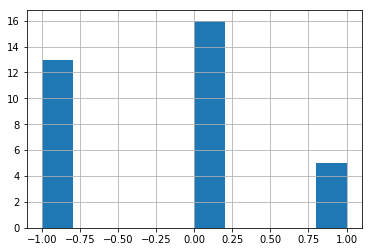

In [43]:
gold_account[gold_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9780de28d0>,
      dtype=object)

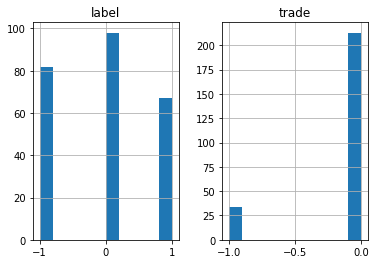

In [44]:
gold_account[['trade', 'label']].hist()

In [45]:
gold_account[gold_account['short'] == 1].gains.sum()

6684.5

In [46]:
gold_account[gold_account['long'] == 1].gains.sum()

0.0

[0.17270487 0.17549588 0.18325186 0.20770647 0.20892917 0.2103281
 0.21420822 0.2182343  0.22026495 0.22033114 0.22938015 0.2352259
 0.24768688 0.24803346 0.24864967 0.25012404 0.25926906 0.25974381
 0.26202429 0.26419139 0.26663587 0.27296868 0.27316982 0.27502066
 0.28198913 0.28474418 0.29169111 0.29556609 0.29771002 0.30068249
 0.30830694 0.31097932 0.31815012 0.32379032 0.32581541 0.32900279
 0.32900482 0.33016489 0.3332093  0.33447732 0.33528956 0.34374639
 0.34458518 0.34495326 0.34554378 0.34598912 0.34935598 0.3509624
 0.35290108 0.35369486 0.35607039 0.36060282 0.36192513 0.36428533
 0.36550448 0.36654816 0.36669133 0.37127114 0.37697784 0.3775922
 0.38000796 0.38283608 0.38423346 0.38506022 0.38576123 0.38793113
 0.38819127 0.38935695 0.39296509 0.3929805  0.39372363 0.39773066
 0.40108183 0.40137589 0.40144082 0.40197941 0.40470538 0.40501307
 0.40507735 0.40637376 0.4071425  0.40751083 0.4075531  0.40770671
 0.40820392 0.40858169 0.41005968 0.41160761 0.41227509 0.41454444

(0, 14000)

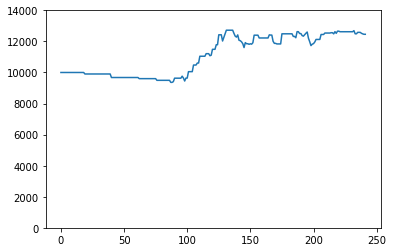

In [47]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=True, stop_loss=400)
ax1 = corn_account.account.plot()
ax1.set_ylim(0,14000)

In [48]:
corn_account[corn_account['short'] == 1].gains.sum()

2459.25

In [49]:
corn_account[corn_account['long'] == 1].gains.sum()

0.0

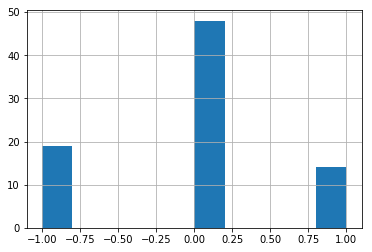

In [50]:
corn_account[corn_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f976a7cb518>,
      dtype=object)

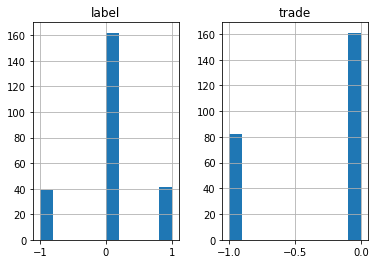

In [51]:
corn_account[['trade', 'label']].hist()

[0.28188446 0.28678037 0.29754178 0.29826651 0.3208234  0.33148159
 0.33318683 0.33798435 0.33862181 0.34641971 0.35623517 0.3576055
 0.35828533 0.35918654 0.360586   0.36086722 0.3624088  0.36377882
 0.36487345 0.36546208 0.36890629 0.36907297 0.36907404 0.37005399
 0.37155091 0.37165721 0.37180942 0.372681   0.37405107 0.37580906
 0.3764355  0.3767186  0.3768506  0.37700392 0.37871105 0.37879217
 0.37959722 0.38082621 0.38259967 0.3844684  0.38475035 0.38664539
 0.38771642 0.3893124  0.39035943 0.39301562 0.39494356 0.39572476
 0.39642076 0.39798525 0.39964678 0.40003388 0.40021839 0.40159748
 0.40192342 0.40341288 0.40528564 0.40560173 0.40563196 0.40648079
 0.4069306  0.40760631 0.40992981 0.4102626  0.41067811 0.41069051
 0.41147092 0.41152994 0.41176661 0.41346416 0.4139386  0.41667163
 0.41715401 0.4186174  0.41865569 0.41910294 0.41936724 0.41943189
 0.41954445 0.4201745  0.42101069 0.42178575 0.42207797 0.42272064
 0.42274687 0.42462469 0.42612512 0.42649262 0.42700973 0.42713

(0, 19000)

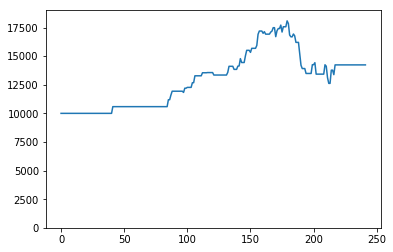

In [52]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, short=coffee_short, stop_loss=1000)
ax1 = coffee_account.account.plot()
ax1.set_ylim(0,19000)

In [53]:
coffee_account[coffee_account['short'] == 1].gains.sum()

4234.937500000002

In [54]:
coffee_account[coffee_account['long'] == 1].gains.sum()

0.0

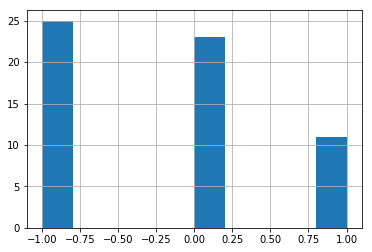

In [55]:
coffee_account[coffee_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f976a5c6a90>,
      dtype=object)

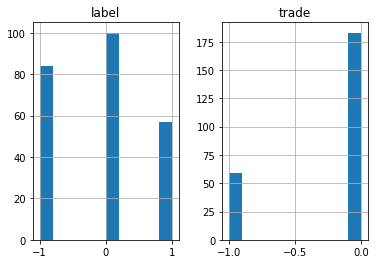

In [56]:
coffee_account[['trade', 'label']].hist()

In [57]:
# %%capture gold_long_train
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

X = pca_transform(gold_train, gold_pca)
y = list(map(lambda x: 1 if x > 0 else 0, gold_label_train))
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x > 0 else 0, gold_label_test))

gold_clf_long = MLPClassifier(solver='lbfgs', alpha=1e-2,
                              hidden_layer_sizes=(10, 20, 2), random_state=55431)
gold_clf_long.fit(np.concatenate([X, X_test]), np.concatenate([y, y_test]))

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=55431, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [58]:
%%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras import regularizers

X_train = np.concatenate([X, X_test])
y_train = np.array([[1,0] if i==1 else [0,0] for i in np.concatenate([y, y_test])])

input_shape = (10, )
num_classes = 1

# Define a model
model = Sequential()  
model.add(Dense(64, input_dim=10, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)

model.summary()

In [59]:
gold_clf_long = model

[1.9765392e-05 1.9802770e-05 1.9855792e-05 1.9990292e-05 2.0044583e-05
 2.0053627e-05 2.0091238e-05 2.0109854e-05 2.0131249e-05 2.0232486e-05
 2.0282056e-05 2.0301757e-05 2.0384206e-05 2.0392237e-05 2.0491287e-05
 2.0523285e-05 2.0698097e-05 2.0910185e-05 2.0923550e-05 2.0971293e-05
 2.0978754e-05 2.0979975e-05 2.0988180e-05 2.0993746e-05 2.1011792e-05
 2.1015179e-05 2.1055339e-05 2.1084836e-05 2.1108899e-05 2.1140086e-05
 2.1161019e-05 2.1164935e-05 2.1189453e-05 2.1195799e-05 2.1204514e-05
 2.1208944e-05 2.1216892e-05 2.1236508e-05 2.1279648e-05 2.1286751e-05
 2.1305619e-05 2.1310861e-05 2.1316228e-05 2.1321861e-05 2.1323976e-05
 2.1369373e-05 2.1373775e-05 2.1383765e-05 2.1387395e-05 2.1395637e-05
 2.1396861e-05 2.1402841e-05 2.1434726e-05 2.1443557e-05 2.1448875e-05
 2.1463076e-05 2.1483023e-05 2.1516791e-05 2.1535901e-05 2.1543152e-05
 2.1544427e-05 2.1544611e-05 2.1627367e-05 2.1649859e-05 2.1653927e-05
 2.1676466e-05 2.1726635e-05 2.1727546e-05 2.1752903e-05 2.1754460e-05
 2.175

(0, 18000)

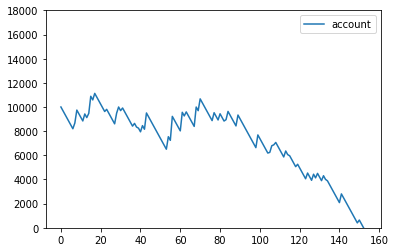

In [60]:
gold_account_long = get_performance(gold_clf_long, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=False, stop_loss=300, multi_class=True, vector=False)
ax1 = gold_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [61]:
gold_account_long[gold_account_long['long'] == 1].gains.sum()

-10257.499999999936

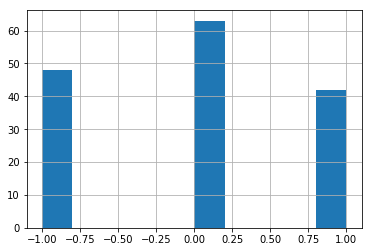

In [62]:
gold_account_long[gold_account_long['long'] == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9740347208>,
      dtype=object)

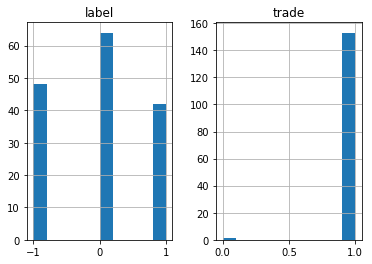

In [63]:
gold_account_long[['trade', 'label']].hist()

In [64]:
# %%capture cpt_corn_train
import keras_metrics
X = pca_transform(corn_train, corn_pca)
X_test = pca_transform(corn_test, corn_pca)

y = list(map(lambda x: 1 if x > 0 else 0, corn_label_train))
y_test = list(map(lambda x: 1 if x > 0 else 0, corn_label_test))

model = Sequential()  
model.add(Dense(32, input_dim=10, activity_regularizer=regularizers.l2(0.01)))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('softmax'))

opt = Nadam(lr=0.02)

model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=[keras_metrics.precision()])
model.fit(X, y, epochs=20, validation_data=(X_test, y_test), batch_size=128, shuffle=True)

model.summary()

corn_clf_long = model

Train on 2221 samples, validate on 556 samples
Epoch 1/20
2221/2221 [==============================] - 0s 119us/step - loss: 4037.7817 - precision: 0.3215 - val_loss: 424.0838 - val_precision: 0.3165
Epoch 2/20
2221/2221 [==============================] - 0s 14us/step - loss: 317.6567 - precision: 0.3215 - val_loss: 175.9430 - val_precision: 0.3165
Epoch 3/20
2221/2221 [==============================] - 0s 13us/step - loss: 142.1609 - precision: 0.3215 - val_loss: 86.9568 - val_precision: 0.3165
Epoch 4/20
2221/2221 [==============================] - 0s 12us/step - loss: 73.9647 - precision: 0.3215 - val_loss: 50.6793 - val_precision: 0.3165
Epoch 5/20
2221/2221 [==============================] - 0s 12us/step - loss: 43.9063 - precision: 0.3215 - val_loss: 29.8304 - val_precision: 0.3165
Epoch 6/20
2221/2221 [==============================] - 0s 13us/step - loss: 26.7062 - precision: 0.3215 - val_loss: 20.8746 - val_precision: 0.3165
Epoch 7/20
2221/2221 [==============================

[1.]
0


(0, 18000)

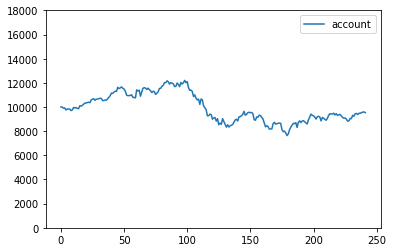

In [65]:
corn_account_long = get_performance(corn_clf_long, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=False, stop_loss=500, vector=True, multi_class=False)
ax1 = corn_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [66]:
corn_account_long[corn_account_long['long'] == 1].gains.sum()

-466.6250000000002

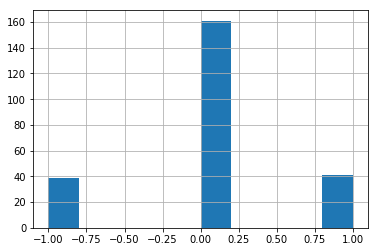

In [67]:
corn_account_long[corn_account_long['long'] == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97382398d0>,
      dtype=object)

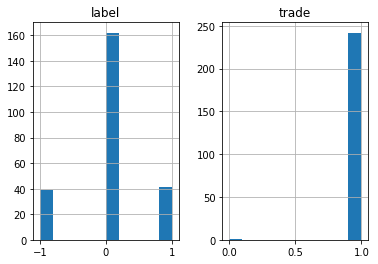

In [68]:
corn_account_long[['trade', 'label']].hist()

In [69]:
# %%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)
X_test = pca_transform(coffee_test, coffee_pca)
y = list(map(lambda x: 1 if x < 0 else 0, coffee_label_test))
model = Sequential()  
model.add(Dense(64, input_dim=10, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2)

model.summary()

corn_clf_long = model
coffee_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])

Epoch 1/2
2782/2782 [==============================] - 1s 325us/step - loss: 809.3498 - acc: 0.8372
Epoch 2/2
2782/2782 [==============================] - 0s 53us/step - loss: 97.1441 - acc: 0.9741
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                704       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
batch_norm

[182]	valid_0's binary_error: 0.351986
[183]	valid_0's binary_error: 0.351986
[184]	valid_0's binary_error: 0.351986
[185]	valid_0's binary_error: 0.351986
[186]	valid_0's binary_error: 0.351986
[187]	valid_0's binary_error: 0.351986
[188]	valid_0's binary_error: 0.351986
[189]	valid_0's binary_error: 0.351986
[190]	valid_0's binary_error: 0.351986
[191]	valid_0's binary_error: 0.351986
[192]	valid_0's binary_error: 0.351986
[193]	valid_0's binary_error: 0.351986
[194]	valid_0's binary_error: 0.351986
[195]	valid_0's binary_error: 0.351986
[196]	valid_0's binary_error: 0.351986
[197]	valid_0's binary_error: 0.351986
[198]	valid_0's binary_error: 0.351986
[199]	valid_0's binary_error: 0.351986
[200]	valid_0's binary_error: 0.351986
[201]	valid_0's binary_error: 0.351986
[202]	valid_0's binary_error: 0.351986
[203]	valid_0's binary_error: 0.351986
[204]	valid_0's binary_error: 0.351986
[205]	valid_0's binary_error: 0.351986
[206]	valid_0's binary_error: 0.351986
[207]	valid_0's binary_er

[394]	valid_0's binary_error: 0.351986
[395]	valid_0's binary_error: 0.351986
[396]	valid_0's binary_error: 0.351986
[397]	valid_0's binary_error: 0.351986
[398]	valid_0's binary_error: 0.351986
[399]	valid_0's binary_error: 0.351986
[400]	valid_0's binary_error: 0.351986
[401]	valid_0's binary_error: 0.351986
[402]	valid_0's binary_error: 0.351986
[403]	valid_0's binary_error: 0.351986
[404]	valid_0's binary_error: 0.351986
[405]	valid_0's binary_error: 0.351986
[406]	valid_0's binary_error: 0.351986
[407]	valid_0's binary_error: 0.351986
[408]	valid_0's binary_error: 0.351986
[409]	valid_0's binary_error: 0.351986
[410]	valid_0's binary_error: 0.351986
[411]	valid_0's binary_error: 0.351986
[412]	valid_0's binary_error: 0.351986
[413]	valid_0's binary_error: 0.351986
[414]	valid_0's binary_error: 0.351986
[415]	valid_0's binary_error: 0.351986
[416]	valid_0's binary_error: 0.351986
[417]	valid_0's binary_error: 0.351986
[418]	valid_0's binary_error: 0.351986
[419]	valid_0's binary_er

[608]	valid_0's binary_error: 0.351986
[609]	valid_0's binary_error: 0.351986
[610]	valid_0's binary_error: 0.351986
[611]	valid_0's binary_error: 0.351986
[612]	valid_0's binary_error: 0.351986
[613]	valid_0's binary_error: 0.351986
[614]	valid_0's binary_error: 0.351986
[615]	valid_0's binary_error: 0.351986
[616]	valid_0's binary_error: 0.351986
[617]	valid_0's binary_error: 0.351986
[618]	valid_0's binary_error: 0.351986
[619]	valid_0's binary_error: 0.351986
[620]	valid_0's binary_error: 0.351986
[621]	valid_0's binary_error: 0.351986
[622]	valid_0's binary_error: 0.351986
[623]	valid_0's binary_error: 0.351986
[624]	valid_0's binary_error: 0.351986
[625]	valid_0's binary_error: 0.351986
[626]	valid_0's binary_error: 0.351986
[627]	valid_0's binary_error: 0.351986
[628]	valid_0's binary_error: 0.351986
[629]	valid_0's binary_error: 0.351986
[630]	valid_0's binary_error: 0.351986
[631]	valid_0's binary_error: 0.351986
[632]	valid_0's binary_error: 0.351986
[633]	valid_0's binary_er

[819]	valid_0's binary_error: 0.353791
[820]	valid_0's binary_error: 0.353791
[821]	valid_0's binary_error: 0.353791
[822]	valid_0's binary_error: 0.353791
[823]	valid_0's binary_error: 0.353791
[824]	valid_0's binary_error: 0.353791
[825]	valid_0's binary_error: 0.353791
[826]	valid_0's binary_error: 0.353791
[827]	valid_0's binary_error: 0.353791
[828]	valid_0's binary_error: 0.353791
[829]	valid_0's binary_error: 0.353791
[830]	valid_0's binary_error: 0.353791
[831]	valid_0's binary_error: 0.353791
[832]	valid_0's binary_error: 0.353791
[833]	valid_0's binary_error: 0.353791
[834]	valid_0's binary_error: 0.353791
[835]	valid_0's binary_error: 0.353791
[836]	valid_0's binary_error: 0.353791
[837]	valid_0's binary_error: 0.353791
[838]	valid_0's binary_error: 0.353791
[839]	valid_0's binary_error: 0.353791
[840]	valid_0's binary_error: 0.353791
[841]	valid_0's binary_error: 0.353791
[842]	valid_0's binary_error: 0.353791
[843]	valid_0's binary_error: 0.353791
[844]	valid_0's binary_er

[1029]	valid_0's binary_error: 0.351986
[1030]	valid_0's binary_error: 0.351986
[1031]	valid_0's binary_error: 0.351986
[1032]	valid_0's binary_error: 0.351986
[1033]	valid_0's binary_error: 0.351986
[1034]	valid_0's binary_error: 0.351986
[1035]	valid_0's binary_error: 0.351986
[1036]	valid_0's binary_error: 0.351986
[1037]	valid_0's binary_error: 0.351986
[1038]	valid_0's binary_error: 0.351986
[1039]	valid_0's binary_error: 0.351986
[1040]	valid_0's binary_error: 0.351986
[1041]	valid_0's binary_error: 0.351986
[1042]	valid_0's binary_error: 0.351986
[1043]	valid_0's binary_error: 0.351986
[1044]	valid_0's binary_error: 0.351986
[1045]	valid_0's binary_error: 0.351986
[1046]	valid_0's binary_error: 0.351986
[1047]	valid_0's binary_error: 0.351986
[1048]	valid_0's binary_error: 0.351986
[1049]	valid_0's binary_error: 0.351986
[1050]	valid_0's binary_error: 0.351986
[1051]	valid_0's binary_error: 0.351986
[1052]	valid_0's binary_error: 0.351986
[1053]	valid_0's binary_error: 0.351986


[1235]	valid_0's binary_error: 0.351986
[1236]	valid_0's binary_error: 0.351986
[1237]	valid_0's binary_error: 0.351986
[1238]	valid_0's binary_error: 0.351986
[1239]	valid_0's binary_error: 0.351986
[1240]	valid_0's binary_error: 0.351986
[1241]	valid_0's binary_error: 0.351986
[1242]	valid_0's binary_error: 0.351986
[1243]	valid_0's binary_error: 0.351986
[1244]	valid_0's binary_error: 0.351986
[1245]	valid_0's binary_error: 0.351986
[1246]	valid_0's binary_error: 0.351986
[1247]	valid_0's binary_error: 0.351986
[1248]	valid_0's binary_error: 0.351986
[1249]	valid_0's binary_error: 0.351986
[1250]	valid_0's binary_error: 0.351986
[1251]	valid_0's binary_error: 0.351986
[1252]	valid_0's binary_error: 0.351986
[1253]	valid_0's binary_error: 0.351986
[1254]	valid_0's binary_error: 0.351986
[1255]	valid_0's binary_error: 0.351986
[1256]	valid_0's binary_error: 0.351986
[1257]	valid_0's binary_error: 0.351986
[1258]	valid_0's binary_error: 0.351986
[1259]	valid_0's binary_error: 0.351986


[1457]	valid_0's binary_error: 0.353791
[1458]	valid_0's binary_error: 0.353791
[1459]	valid_0's binary_error: 0.353791
[1460]	valid_0's binary_error: 0.353791
[1461]	valid_0's binary_error: 0.353791
[1462]	valid_0's binary_error: 0.353791
[1463]	valid_0's binary_error: 0.353791
[1464]	valid_0's binary_error: 0.353791
[1465]	valid_0's binary_error: 0.353791
[1466]	valid_0's binary_error: 0.353791
[1467]	valid_0's binary_error: 0.353791
[1468]	valid_0's binary_error: 0.353791
[1469]	valid_0's binary_error: 0.353791
[1470]	valid_0's binary_error: 0.353791
[1471]	valid_0's binary_error: 0.353791
[1472]	valid_0's binary_error: 0.353791
[1473]	valid_0's binary_error: 0.353791
[1474]	valid_0's binary_error: 0.353791
[1475]	valid_0's binary_error: 0.353791
[1476]	valid_0's binary_error: 0.353791
[1477]	valid_0's binary_error: 0.353791
[1478]	valid_0's binary_error: 0.353791
[1479]	valid_0's binary_error: 0.353791
[1480]	valid_0's binary_error: 0.353791
[1481]	valid_0's binary_error: 0.353791


[1665]	valid_0's binary_error: 0.353791
[1666]	valid_0's binary_error: 0.353791
[1667]	valid_0's binary_error: 0.353791
[1668]	valid_0's binary_error: 0.353791
[1669]	valid_0's binary_error: 0.353791
[1670]	valid_0's binary_error: 0.353791
[1671]	valid_0's binary_error: 0.353791
[1672]	valid_0's binary_error: 0.353791
[1673]	valid_0's binary_error: 0.353791
[1674]	valid_0's binary_error: 0.353791
[1675]	valid_0's binary_error: 0.353791
[1676]	valid_0's binary_error: 0.353791
[1677]	valid_0's binary_error: 0.353791
[1678]	valid_0's binary_error: 0.353791
[1679]	valid_0's binary_error: 0.353791
[1680]	valid_0's binary_error: 0.353791
[1681]	valid_0's binary_error: 0.353791
[1682]	valid_0's binary_error: 0.353791
[1683]	valid_0's binary_error: 0.353791
[1684]	valid_0's binary_error: 0.353791
[1685]	valid_0's binary_error: 0.353791
[1686]	valid_0's binary_error: 0.353791
[1687]	valid_0's binary_error: 0.353791
[1688]	valid_0's binary_error: 0.353791
[1689]	valid_0's binary_error: 0.353791


[1885]	valid_0's binary_error: 0.351986
[1886]	valid_0's binary_error: 0.351986
[1887]	valid_0's binary_error: 0.351986
[1888]	valid_0's binary_error: 0.351986
[1889]	valid_0's binary_error: 0.351986
[1890]	valid_0's binary_error: 0.351986
[1891]	valid_0's binary_error: 0.351986
[1892]	valid_0's binary_error: 0.351986
[1893]	valid_0's binary_error: 0.351986
[1894]	valid_0's binary_error: 0.351986
[1895]	valid_0's binary_error: 0.351986
[1896]	valid_0's binary_error: 0.351986
[1897]	valid_0's binary_error: 0.351986
[1898]	valid_0's binary_error: 0.351986
[1899]	valid_0's binary_error: 0.351986
[1900]	valid_0's binary_error: 0.351986
[1901]	valid_0's binary_error: 0.351986
[1902]	valid_0's binary_error: 0.351986
[1903]	valid_0's binary_error: 0.351986
[1904]	valid_0's binary_error: 0.351986
[1905]	valid_0's binary_error: 0.351986
[1906]	valid_0's binary_error: 0.351986
[1907]	valid_0's binary_error: 0.351986
[1908]	valid_0's binary_error: 0.351986
[1909]	valid_0's binary_error: 0.351986


[2100]	valid_0's binary_error: 0.351986
[2101]	valid_0's binary_error: 0.351986
[2102]	valid_0's binary_error: 0.351986
[2103]	valid_0's binary_error: 0.351986
[2104]	valid_0's binary_error: 0.351986
[2105]	valid_0's binary_error: 0.351986
[2106]	valid_0's binary_error: 0.351986
[2107]	valid_0's binary_error: 0.351986
[2108]	valid_0's binary_error: 0.351986
[2109]	valid_0's binary_error: 0.351986
[2110]	valid_0's binary_error: 0.351986
[2111]	valid_0's binary_error: 0.351986
[2112]	valid_0's binary_error: 0.351986
[2113]	valid_0's binary_error: 0.351986
[2114]	valid_0's binary_error: 0.351986
[2115]	valid_0's binary_error: 0.353791
[2116]	valid_0's binary_error: 0.353791
[2117]	valid_0's binary_error: 0.353791
[2118]	valid_0's binary_error: 0.353791
[2119]	valid_0's binary_error: 0.353791
[2120]	valid_0's binary_error: 0.353791
[2121]	valid_0's binary_error: 0.353791
[2122]	valid_0's binary_error: 0.353791
[2123]	valid_0's binary_error: 0.353791
[2124]	valid_0's binary_error: 0.353791


[2309]	valid_0's binary_error: 0.353791
[2310]	valid_0's binary_error: 0.353791
[2311]	valid_0's binary_error: 0.353791
[2312]	valid_0's binary_error: 0.353791
[2313]	valid_0's binary_error: 0.353791
[2314]	valid_0's binary_error: 0.353791
[2315]	valid_0's binary_error: 0.353791
[2316]	valid_0's binary_error: 0.353791
[2317]	valid_0's binary_error: 0.353791
[2318]	valid_0's binary_error: 0.353791
[2319]	valid_0's binary_error: 0.353791
[2320]	valid_0's binary_error: 0.353791
[2321]	valid_0's binary_error: 0.353791
[2322]	valid_0's binary_error: 0.353791
[2323]	valid_0's binary_error: 0.353791
[2324]	valid_0's binary_error: 0.353791
[2325]	valid_0's binary_error: 0.353791
[2326]	valid_0's binary_error: 0.353791
[2327]	valid_0's binary_error: 0.353791
[2328]	valid_0's binary_error: 0.353791
[2329]	valid_0's binary_error: 0.353791
[2330]	valid_0's binary_error: 0.353791
[2331]	valid_0's binary_error: 0.353791
[2332]	valid_0's binary_error: 0.353791
[2333]	valid_0's binary_error: 0.353791


[2529]	valid_0's binary_error: 0.353791
[2530]	valid_0's binary_error: 0.353791
[2531]	valid_0's binary_error: 0.353791
[2532]	valid_0's binary_error: 0.353791
[2533]	valid_0's binary_error: 0.353791
[2534]	valid_0's binary_error: 0.353791
[2535]	valid_0's binary_error: 0.353791
[2536]	valid_0's binary_error: 0.353791
[2537]	valid_0's binary_error: 0.353791
[2538]	valid_0's binary_error: 0.353791
[2539]	valid_0's binary_error: 0.353791
[2540]	valid_0's binary_error: 0.353791
[2541]	valid_0's binary_error: 0.353791
[2542]	valid_0's binary_error: 0.353791
[2543]	valid_0's binary_error: 0.353791
[2544]	valid_0's binary_error: 0.353791
[2545]	valid_0's binary_error: 0.353791
[2546]	valid_0's binary_error: 0.353791
[2547]	valid_0's binary_error: 0.353791
[2548]	valid_0's binary_error: 0.353791
[2549]	valid_0's binary_error: 0.353791
[2550]	valid_0's binary_error: 0.353791
[2551]	valid_0's binary_error: 0.353791
[2552]	valid_0's binary_error: 0.353791
[2553]	valid_0's binary_error: 0.353791


[2734]	valid_0's binary_error: 0.353791
[2735]	valid_0's binary_error: 0.353791
[2736]	valid_0's binary_error: 0.353791
[2737]	valid_0's binary_error: 0.353791
[2738]	valid_0's binary_error: 0.353791
[2739]	valid_0's binary_error: 0.353791
[2740]	valid_0's binary_error: 0.353791
[2741]	valid_0's binary_error: 0.353791
[2742]	valid_0's binary_error: 0.353791
[2743]	valid_0's binary_error: 0.353791
[2744]	valid_0's binary_error: 0.353791
[2745]	valid_0's binary_error: 0.353791
[2746]	valid_0's binary_error: 0.353791
[2747]	valid_0's binary_error: 0.353791
[2748]	valid_0's binary_error: 0.353791
[2749]	valid_0's binary_error: 0.353791
[2750]	valid_0's binary_error: 0.353791
[2751]	valid_0's binary_error: 0.353791
[2752]	valid_0's binary_error: 0.353791
[2753]	valid_0's binary_error: 0.353791
[2754]	valid_0's binary_error: 0.353791
[2755]	valid_0's binary_error: 0.353791
[2756]	valid_0's binary_error: 0.353791
[2757]	valid_0's binary_error: 0.353791
[2758]	valid_0's binary_error: 0.353791


[2960]	valid_0's binary_error: 0.353791
[2961]	valid_0's binary_error: 0.353791
[2962]	valid_0's binary_error: 0.353791
[2963]	valid_0's binary_error: 0.353791
[2964]	valid_0's binary_error: 0.353791
[2965]	valid_0's binary_error: 0.353791
[2966]	valid_0's binary_error: 0.353791
[2967]	valid_0's binary_error: 0.353791
[2968]	valid_0's binary_error: 0.353791
[2969]	valid_0's binary_error: 0.353791
[2970]	valid_0's binary_error: 0.353791
[2971]	valid_0's binary_error: 0.353791
[2972]	valid_0's binary_error: 0.353791
[2973]	valid_0's binary_error: 0.353791
[2974]	valid_0's binary_error: 0.353791
[2975]	valid_0's binary_error: 0.353791
[2976]	valid_0's binary_error: 0.353791
[2977]	valid_0's binary_error: 0.353791
[2978]	valid_0's binary_error: 0.353791
[2979]	valid_0's binary_error: 0.353791
[2980]	valid_0's binary_error: 0.353791
[2981]	valid_0's binary_error: 0.353791
[2982]	valid_0's binary_error: 0.353791
[2983]	valid_0's binary_error: 0.353791
[2984]	valid_0's binary_error: 0.353791


0
0.50224106089347
0.509262799090763
0.548865646750256
0.5889686239981899
0.5983702981003012
0.6134319719351231
0.6385920403026503


(0, 20000)

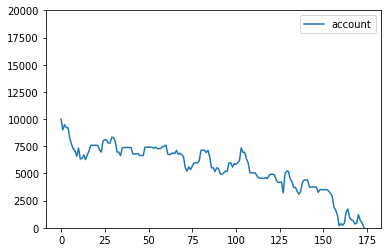

In [146]:
coffee_account_long = get_performance(coffee_clf_long, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], corn_validate, coffee_label_validate, short=False, stop_loss=1000)
ax1 = coffee_account_long[['account']].plot()
ax1.set_ylim(0,20000)

In [147]:
coffee_account_long.head(10)

,account,trade,label,short,long,stop_loss,gains
0,10000.0000,0,0.0,0,0,0,0.0000
1,9000.0000,1,-1.0,0,1,1,-1000.0000
2,9479.4375,1,1.0,0,1,0,479.4375
3,9210.7500,1,0.0,0,1,0,-268.6875
4,9210.7500,0,-1.0,0,0,0,0.0000
5,8210.7500,1,0.0,0,1,1,-1000.0000
6,7674.8750,1,-1.0,0,1,0,-535.8750
7,7263.6875,1,-1.0,0,1,0,-411.1875
8,7066.2500,1,0.0,0,1,0,-197.4375
9,6583.8125,1,-1.0,0,1,0,-482.4375


In [115]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

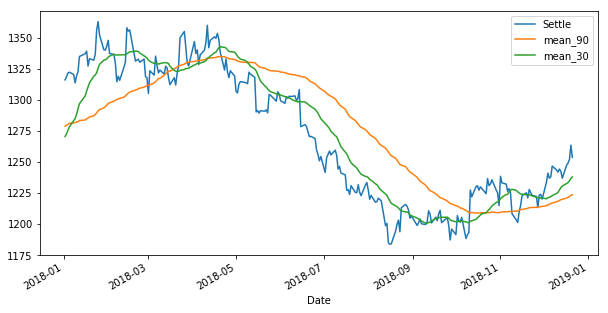

In [114]:
gold = mean_calculation(gold, 90, 30)
gold[['Settle', 'mean_90', 'mean_30']].loc[gold.index > validate_date].plot(figsize=(10,5))

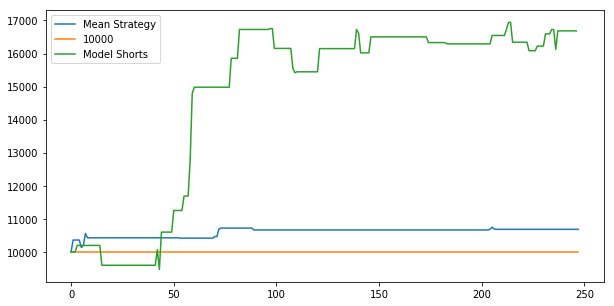

In [172]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           gold_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5))

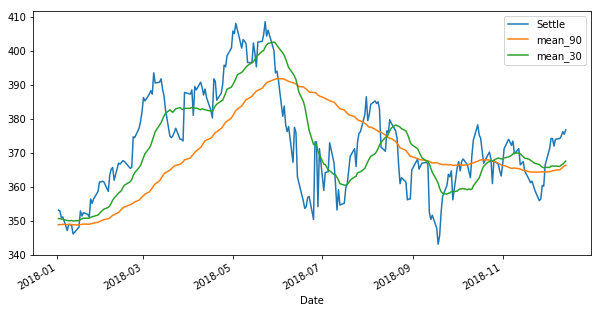

In [149]:
corn = mean_calculation(corn, 90, 30)
corn[['Settle', 'mean_90', 'mean_30']].loc[corn.index > validate_date].plot(figsize=(10,5))

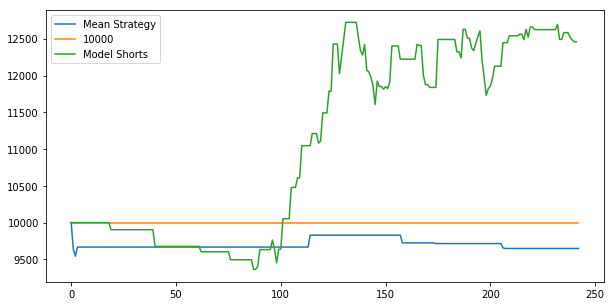

In [169]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           corn_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5))

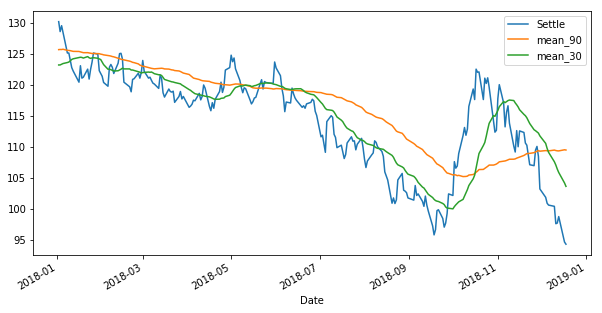

In [151]:
coffee = mean_calculation(coffee, 90, 30)
coffee[['Settle', 'mean_90', 'mean_30']].loc[coffee.index > validate_date].plot(figsize=(10,5))

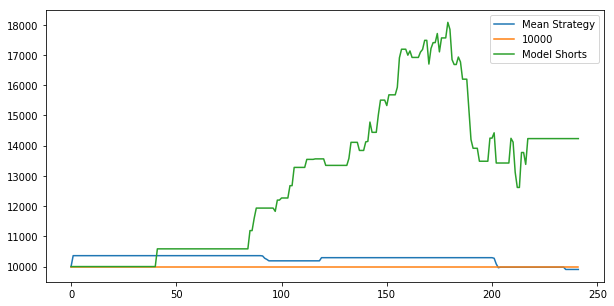

In [174]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           coffee_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5))